# Predicting next-day “heat” for stocks from r/WallStreetBets


#### brief description

## 1. Background & Goal

## 2. Set up, Data Collection, EDA, Pre-Processing

#### Import Libraries

In [1]:

import pandas as pd
import re
import yfinance as yf
from tqdm.auto import tqdm
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from plotly.subplots import make_subplots
import plotly.graph_objects as go


/Users/derekkuang/cse158_assignment2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in main csv
wsb = pd.read_csv("data/wsb.csv")
wsb

,register_index,post_id,comment_id,author,datetime,title,url,score,comments,text,author_post_karma,tag
0,14b78hkjoe86nf,14b78hk,joe86nf,scott_jr,2023-06-16 20:36:55,NaN,NaN,1.0,NaN,Watch til 1 10,32102.0,Meme
1,14b71m2post,14b71m2,NaN,merakibret,2023-06-16 20:24:01,I had my first ever big success with options t...,https://www.reddit.com/r/wallstreetbets/commen...,8.0,6.0,Entered an Iron Condor on ADBE yesterday at 45...,343.0,Gain
2,14b71m2joe6du9,14b71m2,joe6du9,VisualMod,2023-06-16 20:24:07,NaN,NaN,1.0,NaN,User Report Tota...,725083.0,Gain
3,14b71m2joe6een,14b71m2,joe6een,VisualMod,2023-06-16 20:24:13,NaN,NaN,2.0,NaN,That was a very wise move,725083.0,Gain
4,14b71m2joe7yy4,14b71m2,joe7yy4,DreamcatcherEgg,2023-06-16 20:35:23,NaN,NaN,2.0,NaN,All you have to do is repeat this same winning...,6088.0,Gain
...,...,...,...,...,...,...,...,...,...,...,...,...
3033535,1j96owemhd8ajs,1j96owe,mhd8ajs,jarail,2025-03-12 11:25:28,NaN,NaN,4.0,NaN,Hopefully he made the whole story up,NaN,Discussion
3033536,1j96owemhcapeb,1j96owe,mhcapeb,South_Age974,2025-03-12 05:46:48,NaN,NaN,2.0,NaN,holy f,NaN,Discussion
3033537,1j96owemhjt5np,1j96owe,mhjt5np,PickinLosers,2025-03-13 11:49:05,NaN,NaN,2.0,NaN,I like to call them PDFs public domain fries,NaN,Discussion
3033538,1j96owemhex8ls,1j96owe,mhex8ls,The_Whackest,2025-03-12 17:04:15,NaN,NaN,1.0,NaN,Singsongy Some make you laugh and others ma...,NaN,Discussion


In [3]:
# scout dataframe
wsb.info()
wsb.head()
wsb.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033540 entries, 0 to 3033539
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   register_index     object 
 1   post_id            object 
 2   comment_id         object 
 3   author             object 
 4   datetime           object 
 5   title              object 
 6   url                object 
 7   score              float64
 8   comments           float64
 9   text               object 
 10  author_post_karma  float64
 11  tag                object 
dtypes: float64(3), object(9)
memory usage: 277.7+ MB


(3033540, 12)

#### Cleaning the dataframe

In [4]:
# drop uneccessary columns
wsb = wsb.drop(columns=["register_index"])

# convert datetime column to datetime type and normalize to date only
wsb["datetime"] = pd.to_datetime(wsb["datetime"], errors="coerce").dt.normalize()

# convert numeric columns to int type and fill na with 0
numeric_cols = ["score", "comments", "author_post_karma"]
for col in numeric_cols:
    wsb[col] = pd.to_numeric(wsb[col], errors="coerce")
    wsb[col] = wsb[col].fillna(0).astype(int)

# clean and normalize tag column
wsb["tag"] = (
    wsb["tag"].fillna("unknown").str.strip().str.lower().str.replace(r"\s+", "_", regex=True)
)
wsb["tag"] = wsb["tag"].astype("category")

# identify post or comment
wsb["is_post"] = wsb["comment_id"].isna()

# sanity check
wsb.info()
wsb.head()
wsb.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033540 entries, 0 to 3033539
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   post_id            object        
 1   comment_id         object        
 2   author             object        
 3   datetime           datetime64[ns]
 4   title              object        
 5   url                object        
 6   score              int64         
 7   comments           int64         
 8   text               object        
 9   author_post_karma  int64         
 10  tag                category      
 11  is_post            bool          
dtypes: bool(1), category(1), datetime64[ns](1), int64(3), object(6)
memory usage: 237.2+ MB


(3033540, 12)

#### basic filtering / denoising

In [5]:
# remove obvious bot/moderator authors
bot_users = ["VisualMod", "AutoModerator"]
wsb = wsb[~wsb["author"].isin(bot_users)]

# drop rows with deleted/empty content
garbage_tokens = {"", "[deleted]", "[removed]"}
title_clean = wsb["title"].fillna("").str.strip()
text_clean = wsb["text"].fillna("").str.strip()

title_garbage = title_clean.isin(garbage_tokens)
text_garbage = text_clean.isin(garbage_tokens)

post_mask = wsb["is_post"]
comment_mask = ~wsb["is_post"]

drop_mask = (post_mask & title_garbage & text_garbage) | (comment_mask & text_garbage)
wsb = wsb[~drop_mask]

wsb.shape

(2956091, 12)

#### Light intial text cleaning

In [6]:
# build canonical text field for NLP
title_component = wsb["title"].fillna("").astype(str)
text_component = wsb["text"].fillna("").astype(str)

post_raw_text = (title_component + "\n\n" + text_component).str.strip()
comment_raw_text = text_component.str.strip()

wsb["raw_text"] = post_raw_text.where(wsb["is_post"], comment_raw_text)
wsb = wsb[wsb["raw_text"] != ""]

# light text normalization for downstream models
url_pattern = re.compile(r"http\S+")

def clean_text_value(s: str) -> str:
    s = str(s)
    s = url_pattern.sub("", s)
    s = s.replace("\n", " ")
    s = re.sub(r"\s+", " ", s)
    return s.strip()

wsb["clean_text"] = wsb["raw_text"].map(clean_text_value).str.lower()


wsb.shape

(2956091, 14)

#### Save cleaned df

In [7]:
wsb.to_csv("data/wsb_cleaned.csv", index=False)

In [8]:
# Read in cleaned csv
wsb = pd.read_csv('data/wsb_cleaned.csv')

#### Extract and Identify Stock Symbol from content

In [9]:
# Simple regexes
cashtag_pattern = re.compile(r'\$[A-Za-z]{1,5}')
upper_pattern   = re.compile(r'\b[A-Z]{2,5}\b')  # 2–5 uppercase letters

def extract_candidate_tokens(text):
    if not isinstance(text, str):
        return []

    cands = set()

    # $TSLA, $GME
    for m in cashtag_pattern.findall(text):
        cands.add(m[1:].upper())  # strip '$'

    # TSLA, GME, NVDA (bare tickers)
    for m in upper_pattern.findall(text):
        cands.add(m.upper())

    return list(cands)

wsb['candidate_tokens'] = wsb['raw_text'].apply(extract_candidate_tokens)

tokens_exploded = wsb.explode('candidate_tokens')
tokens_exploded = tokens_exploded.dropna(subset=['candidate_tokens'])

token_counts = (
    tokens_exploded
    .groupby('candidate_tokens')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

token_counts.head(30)



# Count of stock mentions

,candidate_tokens,count
11132,NVDA,49561
381,AI,40492
16203,US,29507
11519,OP,26281
14563,SPY,25820
17298,WSB,19541
15743,TSLA,17708
578,AMD,13938
2545,CEO,10445
3621,DD,9184


#### Filter valid stock sybmols

- cross check with yahoo finance to make sure stock symbol is valid, manually check and drop 

In [10]:
# 1. Filter candidate tokens (at least mentioned 500 times)

min_count = 500 
freq_candidates = (
    token_counts[token_counts['count'] >= min_count]['candidate_tokens']
    .astype(str)
    .tolist()
)

print(f"Number of freq_candidates (count >= {min_count}): {len(freq_candidates)}")

Number of freq_candidates (count >= 500): 303


In [11]:
# 2. Build valid_tickers via yfinance (check if symbol has price data)

start_date = '2023-06-08'
end_date   = '2025-04-02'

valid_tickers_all = []

for sym in tqdm(freq_candidates, desc="Checking yfinance symbols"):
    try:
        data = yf.download(sym, start=start_date, end=end_date, progress=False)
        if not data.empty:
            valid_tickers_all.append(sym)
    except Exception:
        # Skip symbols that cause errors
        continue

valid_tickers_all = sorted(set(valid_tickers_all))
print(f"Number of symbols with real price data: {len(valid_tickers_all)}")

Checking yfinance symbols:   0%|          | 0/303 [00:00<?, ?it/s]/var/folders/_m/g3l0_2ld7859l89b672mt3k40000gn/T/ipykernel_94366/3121181422.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sym, start=start_date, end=end_date, progress=False)
Checking yfinance symbols:   0%|          | 1/303 [00:00<01:51,  2.70it/s]/var/folders/_m/g3l0_2ld7859l89b672mt3k40000gn/T/ipykernel_94366/3121181422.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sym, start=start_date, end=end_date, progress=False)
Checking yfinance symbols:   1%|          | 2/303 [00:00<01:06,  4.54it/s]/var/folders/_m/g3l0_2ld7859l89b672mt3k40000gn/T/ipykernel_94366/3121181422.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sym, start=start_date, end=end_date, progress=False)

1 Failed download:
['US']: YFPricesMissingError('possibly delisted; no price dat

Number of symbols with real price data: 161


In [12]:
# 3. Take the top 150 valid tickers by WSB frequency
vc = (
    token_counts[token_counts['candidate_tokens'].isin(valid_tickers_all)]
    .copy()
    .sort_values('count', ascending=False)
)

top_150 = vc['candidate_tokens'].head(150).tolist()

In [13]:
# 4. Remove obviously ambiguous / non-stock symbols

manual_drop = {
    # Common words / pronouns / fillers
    "IT", "AM", "ARE", "FOR", "ALL", "GO", "NOW", "OR", "JUST", "YOU",
    "MORE", "TIME", "LOT", "WAY", "BACK", "DAY",

    # Macro / econ / generic finance
    "US", "USA", "USD", "CPI", "PPI", "EPS", "IRS",
    "IPO", "ITM", "PM", "EOD",

    # Crypto / FX / non-equity focus
    "BTC", "ETH", "SOL", "DOGE", "ADA", "XRP", "USDT", "USDC",

    # Slang / memes / platform lingo
    "YOLO", "WTF", "IMO", "MOON", "GL",

    # Generic financial/technical terms (not single equities)
    "IV", "ETF", "RSI",

    # Regions / places
    "EU", "UK", "NYC", "CA", "DC",

    # Ambiguous tickers that are almost always normal words or other concepts
    "AI", "OP", "DD", "EV", "LINK", "TV", "ON", "UP", "VR", "PC", "SO",
    "IP", "CC", "IQ", "OPEN", "BE", "CAN", "MS", "OS", "PT", "PDT",
    "COST", "DEI", "OUT", "HE", "UI", "PR", "AM", "AGI", "ICE",

    # Misc abbreviations that are usually not equity tickers in WSB text
    "EPS", "CFO", "AA", "GPT", "HERE", "LOVE", "ANY", "EDIT", "RH"
}


filtered_candidates = [t for t in top_150 if t not in manual_drop]
print(f"After manual_drop filtering: {len(filtered_candidates)} symbols")

After manual_drop filtering: 78 symbols


In [14]:
# 5. keep and save the final stock ticker list

vc_filtered = vc[vc['candidate_tokens'].isin(filtered_candidates)].copy()
vc_filtered = vc_filtered.sort_values('count', ascending=False)

final_tickers = vc_filtered['candidate_tokens'].tolist()
print(f"Final ticker universe size: {len(final_tickers)}")
print("Preview final_tickers:", final_tickers[:20])

# Save final universe to JSON for verification
valid_tickers_path = 'data/valid_tickers_top.json'
with open(valid_tickers_path, 'w') as f:
    json.dump(final_tickers, f, indent=2)

print(f"Saved final tickers to {valid_tickers_path}")

valid_tickers_set = set(final_tickers)


Final ticker universe size: 78
Preview final_tickers: ['NVDA', 'SPY', 'TSLA', 'AMD', 'SMCI', 'QQQ', 'AAPL', 'MSFT', 'TSM', 'MSTR', 'AMC', 'PLTR', 'INTC', 'DJT', 'META', 'ASTS', 'ARM', 'AMZN', 'MARA', 'RKLB']
Saved final tickers to data/valid_tickers_top.json


In [15]:
# 6. Re-extract tickers from WSB text using whitelist, save to a final dataframe with one row per (WSB row, ticker)
cashtag_pattern = re.compile(r'\$[A-Za-z]{1,5}')
upper_pattern   = re.compile(r'\b[A-Z]{2,5}\b')

def extract_tickers(text):
    if not isinstance(text, str):
        return []

    cands = set()

    # $TSLA/$GME style
    for m in cashtag_pattern.findall(text):
        cands.add(m[1:].upper())

    # TSLA/GME style (bare)
    for m in upper_pattern.findall(text):
        cands.add(m.upper())

    # keep only in the curated top-100 universe
    return [t for t in cands if t in valid_tickers_set]

wsb['tickers'] = wsb['raw_text'].apply(extract_tickers)

# Keep only rows that mention at least one of our final tickers
wsb_with_ticker = wsb[wsb['tickers'].str.len() > 0].copy()

# One row per (WSB row, ticker)
wsb_exploded = (
    wsb_with_ticker
    .explode('tickers')
    .rename(columns={'tickers': 'ticker'})
)

print("Exploded WSB shape:", wsb_exploded.shape)
print(wsb_exploded[['datetime', 'ticker']].head())

# sanity check ticker counts
print("\nTop 20 tickers after final filter:")
print(wsb_exploded['ticker'].value_counts().head(20))

wsb_exploded.to_csv('data/wsb_exploded.csv', index=False)

Exploded WSB shape: (237237, 16)
      datetime ticker
13  2023-06-16    SPY
26  2023-06-16     TD
30  2023-06-16    IWM
32  2023-06-16    SPY
44  2023-06-16    CCL

Top 20 tickers after final filter:
ticker
NVDA    49561
SPY     25820
TSLA    17708
AMD     13938
SMCI     5930
QQQ      5655
AAPL     5422
MSFT     4839
TSM      4827
MSTR     4191
AMC      4121
PLTR     3992
INTC     3688
DJT      3673
META     3479
ASTS     3062
ARM      2828
AMZN     2714
MARA     2663
RKLB     2320
Name: count, dtype: int64


#### word cloud visualization for interesting words

Building word cloud from wsb_exploded['title'] ...
Generating Title Word Cloud...


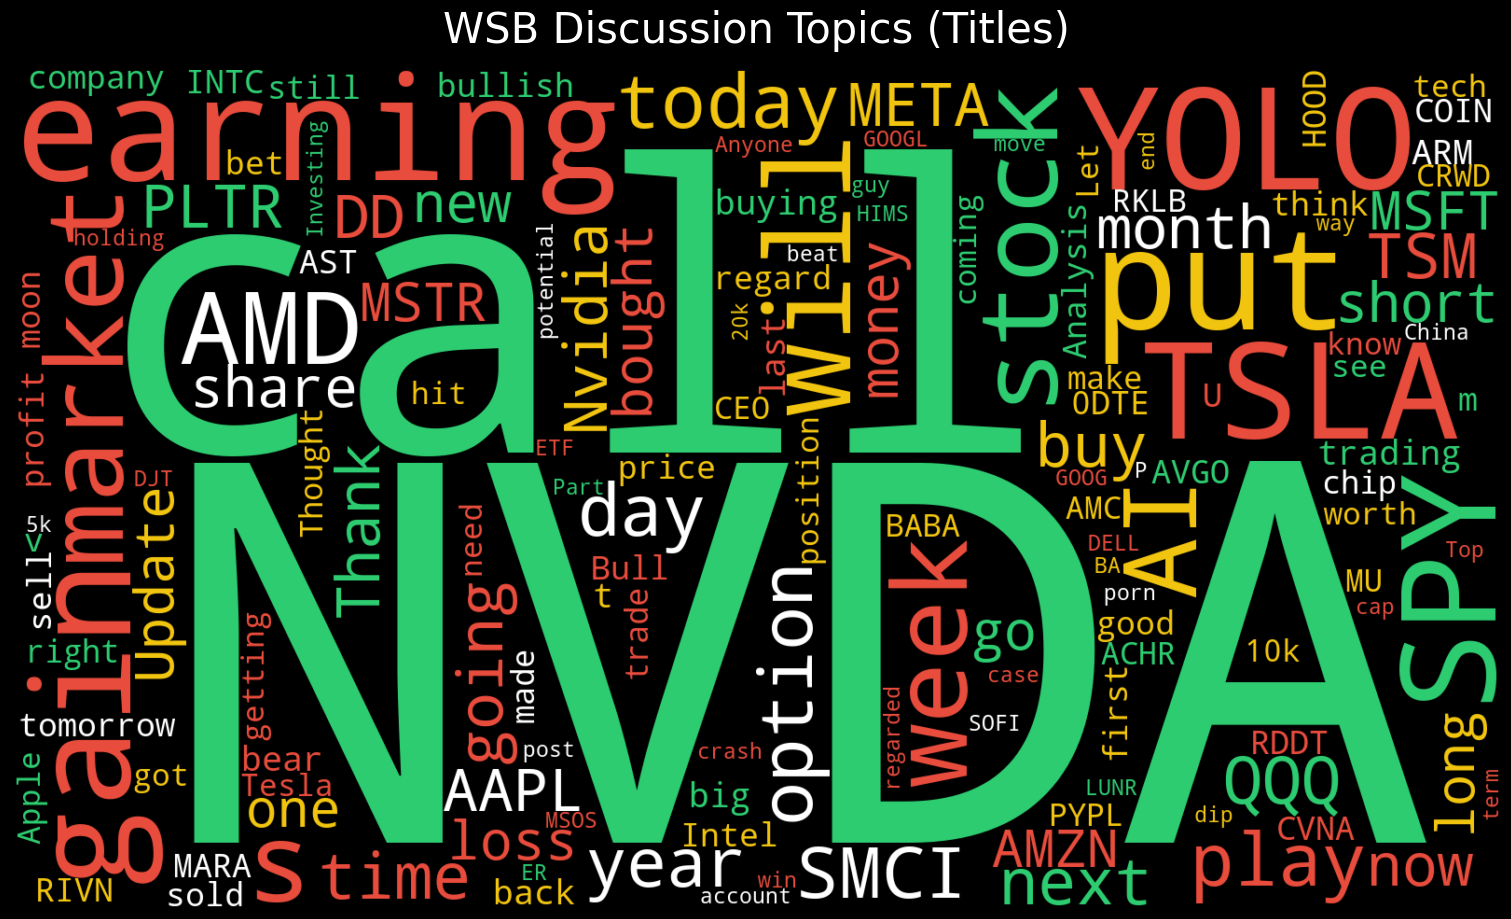

Saved wordcloud to plots/wsb_title_wordcloud.png


In [16]:
wc_df = wsb_exploded.copy()

if 'title' in wc_df.columns:
    print("Building word cloud from wsb_exploded['title'] ...")
    text_titles = " ".join(wc_df['title'].dropna().astype(str).values)
else:
    # Fallback: use raw_text if title is missing
    print("Column 'title' not found, falling back to 'raw_text' ...")
    text_titles = " ".join(wc_df['raw_text'].dropna().astype(str).values)

# --- 2. CLEANING / STOPWORDS ---
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "removed", "deleted", "nan", "https", "com", "www", "reddit", "url",
    "webp", "preview", "auto", "width", "format", "png", "jpg", "image",
    "img", "emote", "t5", "2th52", "31125", "4275", "18632", "00pm"
])

# --- 3. CUSTOM STOCK COLOR FUNCTION ---
def stock_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice([
        "#2ECC71",  # Green (gains / heat)
        "#E74C3C",  # Red (losses)
        "#FFFFFF",  # White
        "#F1C40F"   # Yellow accent
    ])

# --- 4. GENERATE WORD CLOUD ---
print("Generating Title Word Cloud...")
wordcloud = WordCloud(
    width=1600,
    height=900,
    background_color='black',
    stopwords=custom_stopwords,
    min_font_size=12,
    random_state=42,
    max_words=150,
    collocations=False,
    color_func=stock_color_func
).generate(text_titles)

# --- 5. PLOT + SAVE ---
out_path = "plots/wsb_title_wordcloud.png"

plt.figure(figsize=(16, 9), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WSB Discussion Topics (Titles)", fontsize=30, color='white', pad=20)
plt.tight_layout(pad=0)
plt.savefig(out_path, dpi=150, facecolor='k')
plt.show()

print(f"Saved wordcloud to {out_path}")

#### Download Associated Price Data from yahoo finance
- Create a df with daily price data with our final stock list

In [17]:
# 1. Load your final ticker universe from JSON
tickers_path = 'data/valid_tickers_top.json'

with open(tickers_path, 'r') as f:
    final_tickers = json.load(f)

print(f"# tickers: {len(final_tickers)}")
print("Preview:", final_tickers[:10])

# 2. Define date range
start_date = '2023-06-01'
end_date   = '2025-04-02'

# 3. Single multi-ticker download (WIDE, MultiIndex)
raw = yf.download(
    final_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False, 
    progress=False
)

# raw is wide with MultiIndex columns: (PriceField, Ticker)
print("Raw shape:", raw.shape)
print("Column level names:", raw.columns.names)
print(raw.head(3))

# 4. Reshape to LONG: one row per (date, ticker)
# Ensure column levels have names (should already be ['Price', 'Ticker'])
if raw.columns.names is None or len(raw.columns.names) != 2:
    # yfinance usually sets this, but just in case:
    raw.columns.names = ['Price', 'Ticker']

prices_long = (
    raw
    .stack(level='Ticker')          # stack over ticker level → ticker becomes index level
    .reset_index()                  # turn index back into columns
    .rename(columns={'Date': 'datetime', 'Ticker': 'ticker'})
)

# Now columns should be: ['datetime','ticker','Open','High','Low','Close','Adj Close','Volume']
print("After stack → long shape:", prices_long.shape)
print(prices_long.head(3))
print("Columns after stack:", prices_long.columns.tolist())

# 5. Clean column names & add 'date'
prices_long = prices_long.rename(
    columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }
)

prices_long['datetime'] = pd.to_datetime(prices_long['datetime'])

# Sort for sanity
prices_long = prices_long.sort_values(['ticker', 'datetime']).reset_index(drop=True)

print("Final LONG price data shape:", prices_long.shape)
print(prices_long.head(5))
print("Final columns:", prices_long.columns.tolist())

out_path = 'data/prices_daily.csv'
prices_long.to_csv(out_path, index=False)

# tickers: 78
Preview: ['NVDA', 'SPY', 'TSLA', 'AMD', 'SMCI', 'QQQ', 'AAPL', 'MSFT', 'TSM', 'MSTR']
Raw shape: (460, 468)
Column level names: ['Price', 'Ticker']
Price        Adj Close                                               \
Ticker            AAPL  ACHR        AMC         AMD        AMZN ARM   
Date                                                                  
2023-06-01  177.930130  2.99  45.500000  119.470001  122.769997 NaN   
2023-06-02  178.779831  2.96  45.500000  117.860001  124.250000 NaN   
2023-06-05  177.426254  3.00  46.299999  117.930000  125.300003 NaN   

Price                                                ...   Volume            \
Ticker            ASML  ASTS       AVGO          BA  ...     TLRY       TLT   
Date                                                 ...                      
2023-06-01  710.749268  5.60  76.217285  207.960007  ...  2610145  21040400   
2023-06-02  708.675964  5.62  78.344749  213.320007  ...  2127292  19136500   
2023-06-05  706.

/var/folders/_m/g3l0_2ld7859l89b672mt3k40000gn/T/ipykernel_94366/1885167002.py:36: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level='Ticker')          # stack over ticker level → ticker becomes index level


#### Feature Preprocessing

- Price side feature: return, next day label, big move label

In [18]:
# 0. Normalize datetime to day-level but KEEP column name 'datetime'
prices_long['datetime'] = pd.to_datetime(prices_long['datetime']).dt.normalize()
wsb_exploded['datetime'] = pd.to_datetime(wsb_exploded['datetime']).dt.normalize()

# 1. PRICE-SIDE FEATURES: returns + next-day label
prices_feat = prices_long.sort_values(['ticker', 'datetime']).copy()

# Daily return
prices_feat['return'] = prices_feat.groupby('ticker')['close'].pct_change()

# Next-day close and next-day return (per ticker)
prices_feat['next_close'] = prices_feat.groupby('ticker')['close'].shift(-1)
prices_feat['next_return'] = (
    (prices_feat['next_close'] - prices_feat['close']) / prices_feat['close']
)

# Big-move label
BIG_MOVE_THRESH = 0.05  # 5% threshold; adjust if you want
prices_feat['big_move'] = (
    prices_feat['next_return'].abs() >= BIG_MOVE_THRESH
).astype(int)

# Drop rows with no next-day info
prices_feat = prices_feat.dropna(subset=['next_return'])

price_cols = [
    'datetime', 
    'ticker',
    'close',
    'volume',
    'return',
    'next_return',
    'big_move'
]
prices_feat = prices_feat[price_cols]

print(prices_feat.head())

Price   datetime ticker       close       volume    return  next_return  \
0     2023-06-01   AAPL  180.089996   68901800.0       NaN     0.004775   
1     2023-06-02   AAPL  180.949997   61996900.0  0.004775    -0.007571   
2     2023-06-05   AAPL  179.580002  121946500.0 -0.007571    -0.002060   
3     2023-06-06   AAPL  179.210007   64848400.0 -0.002060    -0.007756   
4     2023-06-07   AAPL  177.820007   61944600.0 -0.007756     0.015465   

Price  big_move  
0             0  
1             0  
2             0  
3             0  
4             0  


#### Visualization of returns (big move territory marked)

In [19]:
df_plot = prices_feat[['return']].copy()
df_plot = df_plot.dropna(subset=['return'])
df_plot = df_plot.rename(columns={'return': 'ret'})

# Gain / Loss flag
df_plot['Outcome'] = np.where(df_plot['ret'] >= 0, 'Gain', 'Loss')

# Key stats
mean_val   = df_plot['ret'].mean()
median_val = df_plot['ret'].median()
std_val    = df_plot['ret'].std()
p05        = df_plot['ret'].quantile(0.05)
p95        = df_plot['ret'].quantile(0.95)

# Histogram
fig = px.histogram(
    df_plot,
    x='ret',
    nbins=100,
    range_x=[-0.12, 0.12],  # about -12% to +12%
    color='Outcome',
    color_discrete_map={'Gain': '#2ECC71', 'Loss': '#E74C3C'},
    title='<b>Daily Returns Distribution</b> (with Key Statistics)',
    labels={'ret': 'Daily Return', 'count': 'Frequency'},
    template='plotly_white'
)

fig.update_traces(
    marker_line_color='white',
    marker_line_width=1,
    opacity=0.8
)

# Stats "card"
stats_text = (
    f"<b>Key Metrics:</b><br>"
    f"Mean: {mean_val:.2%}<br>"
    f"Median: {median_val:.2%}<br>"
    f"Std Dev: {std_val:.2%}"
)

fig.add_annotation(
    x=0.98, y=0.98,
    xref="paper", yref="paper",
    text=stats_text,
    showarrow=False,
    align="left",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

# Reference lines: mean + 5% / 95% VaR
fig.add_vline(x=mean_val, line_width=2, line_dash="dash", line_color="#333")
fig.add_vline(x=p05, line_width=1, line_dash="dot", line_color="gray")
fig.add_vline(x=p95, line_width=1, line_dash="dot", line_color="gray")

fig.add_annotation(
    x=p05, y=0.5, yref="paper",
    text="5% VaR",
    showarrow=False,
    xanchor="right",
    font=dict(color="gray", size=10)
)

fig.add_annotation(
    x=p95, y=0.5, yref="paper",
    text="95% VaR",
    showarrow=False,
    xanchor="left",
    font=dict(color="gray", size=10)
)

fig.update_layout(
    xaxis_tickformat='.0%',
    bargap=0.05,
    title_x=0.5,
    margin=dict(t=80),
    legend_title_text=""
)

fig.show()

fig.write_html(
    "plots/daily_returns_distribution.html",
    include_plotlyjs="cdn",  # load Plotly JS from CDN
    full_html=False          # saves just a div+script snippet, easy to embed
)


- WallStreetBet numeric feature

In [20]:
# 2. WSB-SIDE NUMERIC FEATURES per (datetime, ticker)
wsb_num = wsb_exploded.copy()

# is_post: posts have NaN comment_id, comments have non-null
if 'is_post' not in wsb_num.columns:
    wsb_num['is_post'] = wsb_num['comment_id'].isna()

# score numeric
wsb_num['score'] = pd.to_numeric(wsb_num['score'], errors='coerce')

group_cols = ['datetime', 'ticker']

agg_dict = {
    'score': ['count', 'sum', 'mean'],
    'is_post': 'mean',
    'author': pd.Series.nunique,
}

wsb_daily = (
    wsb_num
    .groupby(group_cols)
    .agg(agg_dict)
)

# Flatten columns
wsb_daily.columns = [
    '_'.join([c for c in col if c]) for col in wsb_daily.columns.ravel()
]
wsb_daily = wsb_daily.reset_index()

wsb_daily = wsb_daily.rename(columns={
    'score_count': 'mention_count',
    'score_sum': 'score_sum',
    'score_mean': 'score_mean',
    'is_post_mean': 'post_fraction',
    'author_nunique': 'unique_authors'
})

print("WSB numeric daily feature shape:", wsb_daily.shape)
print(wsb_daily.head())

WSB numeric daily feature shape: (23612, 7)
    datetime ticker  mention_count  score_sum  score_mean  post_fraction  \
0 2023-06-08   AMZN              1          7    7.000000       0.000000   
1 2023-06-08   BABA              1          6    6.000000       0.000000   
2 2023-06-08    BYD              1          1    1.000000       0.000000   
3 2023-06-08    CCL              1         11   11.000000       1.000000   
4 2023-06-08   CVNA             15        455   30.333333       0.133333   

   unique_authors  
0               1  
1               1  
2               1  
3               1  
4              10  


- WallStreetBet Text Features: ticker and text

In [21]:
# 3. WSB TEXT FEATURES: doc_text per (datetime, ticker)

wsb_text = wsb_exploded.copy()

text_col = 'clean_text'

# Ensure string
wsb_text[text_col] = wsb_text[text_col].fillna('').astype(str)

wsb_text_daily = (
    wsb_text
    .groupby(['datetime', 'ticker'])[text_col]
    .apply(lambda s: ' '.join(s))
    .reset_index()
    .rename(columns={text_col: 'doc_text'})
)

print("WSB text daily shape:", wsb_text_daily.shape)
print(wsb_text_daily.head())

WSB text daily shape: (23612, 3)
    datetime ticker                                           doc_text
0 2023-06-08   AMZN  drilling when i m about go go long amzn googl ...
1 2023-06-08   BABA            do i have to be asian to buy baba calls
2 2023-06-08    BYD  no one has ever been able to achieve a monopol...
3 2023-06-08    CCL  market recap - 6/8/23 - the fed boa the fed is...
4 2023-06-08   CVNA  cvna to the moon? 🌚 you guys might want to get...


- Final Merge for all baseline features for a final modeling df

In [22]:
# 4. MERGE: prices + WSB numeric + WSB text

model_df = (
    prices_feat
    .merge(wsb_daily, on=['datetime', 'ticker'], how='inner')
    .merge(wsb_text_daily, on=['datetime', 'ticker'], how='inner')
)

print("Model DF shape:", model_df.shape)
print(model_df.head())
print("Big-move base rate:", model_df['big_move'].mean())

model_df['log_volume'] = np.log1p(model_df['volume'])

# Fill NaNs in WSB features with 0 (no activity)
wsb_cols = ['mention_count', 'score_sum', 'score_mean', 'post_fraction', 'unique_authors']
for c in wsb_cols:
    if c in model_df.columns:
        model_df[c] = model_df[c].fillna(0)

# Drop any rows missing the core numeric features or label
core_numeric = ['return', 'log_volume'] + wsb_cols
model_df = model_df.dropna(subset=core_numeric + ['big_move'])

print("Model df after cleaning:", model_df.shape)


out_path = 'data/modeling_df.csv'
model_df.to_csv(out_path, index=False)


Model DF shape: (16648, 13)
    datetime ticker       close      volume    return  next_return  big_move  \
0 2023-06-09   AAPL  180.960007  48900000.0  0.002160     0.015639         0   
1 2023-06-12   AAPL  183.789993  54274900.0  0.015639    -0.002612         0   
2 2023-06-13   AAPL  183.309998  54929100.0 -0.002612     0.003491         0   
3 2023-06-14   AAPL  183.949997  57462900.0  0.003491     0.011199         0   
4 2023-06-15   AAPL  186.009995  65433200.0  0.011199    -0.005860         0   

   mention_count  score_sum  score_mean  post_fraction  unique_authors  \
0              7         32    4.571429       0.142857               7   
1             18        182   10.111111       0.055556              17   
2             13        215   16.538462       0.076923              13   
3              6         48    8.000000       0.000000               6   
4              8         82   10.250000       0.000000               8   

                                            do

### Previous Wall Street Bet, big next day move? EDA

In [23]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

merged_df = (
    model_df
    [['datetime', 'ticker', 'close', 'next_return', 'mention_count']]
    .copy()
)

merged_df = merged_df.rename(columns={
    'datetime': 'date',
    'next_return': 'next_ret'
})

top_tickers = (
    merged_df['ticker']
    .value_counts()
    .head(10)
    .index
    .tolist()
)

palette = px.colors.qualitative.Plotly
company_colors = {
    t: palette[i % len(palette)]
    for i, t in enumerate(top_tickers)
}

def plot_ticker_attention_vs_moves(ticker, save_html=False):
    df_t = (
        merged_df[merged_df['ticker'] == ticker]
        .sort_values('date')
        .copy()
    )
    if df_t.empty:
        print(f"No data for {ticker}")
        return

    df_t['price_index'] = df_t['close'] / df_t['close'].iloc[0]
    df_t['abs_next_ret'] = df_t['next_ret'].abs()

    high_att_thresh = df_t['mention_count'].quantile(0.9)   
    big_move_thresh = 0.05                                  

    df_t['high_attention'] = df_t['mention_count'] >= high_att_thresh
    df_t['big_move'] = df_t['abs_next_ret'] >= big_move_thresh

    col = company_colors.get(ticker, '#1f77b4')

    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        row_heights=[0.6, 0.4],
        subplot_titles=(
            f'{ticker} price (indexed, high-attention days highlighted)',
            f'{ticker} next-day absolute return (big moves highlighted)'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_t['date'],
            y=df_t['price_index'],
            mode='lines',
            name='Price index',
            line=dict(color=col)
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_t.loc[df_t['high_attention'], 'date'],
            y=df_t.loc[df_t['high_attention'], 'price_index'],
            mode='markers',
            name='High WSB attention',
            marker=dict(
                color='orange',
                size=8,
                symbol='circle-open',
                line=dict(width=2, color='orange')
            )
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=df_t.loc[~df_t['big_move'], 'date'],
            y=df_t.loc[~df_t['big_move'], 'abs_next_ret'],
            name='Normal day (<5%)',
            marker_color='lightgray'
        ),
        row=2, col=1
    )

    fig.add_trace(
        go.Bar(
            x=df_t.loc[df_t['big_move'], 'date'],
            y=df_t.loc[df_t['big_move'], 'abs_next_ret'],
            name='Big move (≥5%)',
            marker_color='crimson'
        ),
        row=2, col=1
    )

    fig.update_yaxes(title_text='Price index (start = 1)', row=1, col=1)
    fig.update_yaxes(
        title_text='|Next-day return|',
        tickformat='.0%',
        row=2, col=1
    )

    fig.update_layout(
        template='plotly_white',
        height=600,
        margin=dict(l=70, r=40, t=130, b=60),
        title=dict(
            text=f'{ticker}: price, WSB attention, and next-day moves',
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top'
        ),
        legend=dict(
            orientation='h',
            yanchor='top',
            y=1.12,
            xanchor='center',
            x=0.5
        )
    )

    fig.show()

    if save_html:
        # Saves to plots/TICKER.html (e.g., plots/NVDA.html)
        fig.write_html(
            f"plots/{ticker}.html",
            include_plotlyjs="cdn",
            full_html=False
        )

In [24]:
plot_ticker_attention_vs_moves('NVDA', True)
plot_ticker_attention_vs_moves('TSLA', True)

In [25]:
# EDA on mention count vs return: higher metion count → higher volatility?

df_bins = model_df[['mention_count', 'return']].dropna().copy()
df_bins['abs_next_ret'] = df_bins['return'].abs()

# Define mention buckets
bin_edges = [0, 2, 4, 10, 20, np.inf]
bin_labels = ['1-2', '3-4', '5-10', '11-20', '21+']

df_bins['mention_bin'] = pd.cut(
    df_bins['mention_count'],
    bins=bin_edges,
    labels=bin_labels,
    right=True,       # (0,2], (2,4], etc.
    include_lowest=True
)

bin_stats = (
    df_bins
    .groupby('mention_bin', observed=False)['abs_next_ret']
    .mean()
    .reset_index()
    .rename(columns={'abs_next_ret': 'mean_abs_next_ret'})
)

print("bin_stats:")
print(bin_stats)

fig = px.bar(
    bin_stats,
    x='mention_bin',
    y='mean_abs_next_ret',
    color='mean_abs_next_ret',
    color_continuous_scale=[
        (0.0, "#D5F5E3"),  # very light green
        (1.0, "#2ECC71")   # your bright green
    ],
    title='<b>Volatility Impact:</b> Average Absolute Return by Mention Count',
    text='mean_abs_next_ret',
    labels={
        'mention_bin': 'Daily Mention Count (WSB)',
        'mean_abs_next_ret': 'Mean |Next-Day Return|'
    },
    template='plotly_white'
)

fig.update_traces(
    texttemplate='%{text:.2%}',      # show as %
    textposition='outside',
    marker_line_color='white',
    marker_line_width=1.5,
    opacity=1.0,
    hovertemplate=(
        '<b>Mentions: %{x}</b><br>'
        'Avg |Next-Day Return|: %{y:.2%}<extra></extra>'
    )
)

fig.update_layout(
    coloraxis_showscale=False,
    yaxis_tickformat='.1%',
    yaxis_title='Average Absolute Return (Volatility)',
    xaxis_title='Daily WSB Mention Count',
    title_x=0.5,
    margin=dict(t=80, b=40)
)


fig.show()

# Interactive HTML (for website embedding)
fig.write_html(
    "plots/wsb_mention_vs_volatility.html",
    include_plotlyjs="cdn",
    full_html=False
)

bin_stats:
  mention_bin  mean_abs_next_ret
0         1-2           0.019560
1         3-4           0.021528
2        5-10           0.024311
3       11-20           0.029529
4         21+           0.039270


## 3. Modeling

### Train / Val / Test Split

In [26]:
def time_split(df, train_frac=0.7, val_frac=0.15):
    """
    Split by datetime (chronological). No shuffling.
    Returns train_df, val_df, test_df.
    """
    df = df.sort_values('datetime')
    unique_times = df['datetime'].unique()
    n = len(unique_times)
    
    train_cut = int(n * train_frac)
    val_cut   = int(n * (train_frac + val_frac))
    
    train_times = unique_times[:train_cut]
    val_times   = unique_times[train_cut:val_cut]
    test_times  = unique_times[val_cut:]
    
    train_df = df[df['datetime'].isin(train_times)].copy()
    val_df   = df[df['datetime'].isin(val_times)].copy()
    test_df  = df[df['datetime'].isin(test_times)].copy()
    
    print(f"Train dates: {train_times[0]} → {train_times[-1]}  ({len(train_times)} days)")
    print(f"Val dates:   {val_times[0]} → {val_times[-1]}      ({len(val_times)} days)")
    print(f"Test dates:  {test_times[0]} → {test_times[-1]}     ({len(test_times)} days)")
    
    return train_df, val_df, test_df

train_df, val_df, test_df = time_split(model_df)

print("Split sizes:",
      len(train_df), "train /",
      len(val_df), "val /",
      len(test_df), "test")

Train dates: 2023-06-08 00:00:00 → 2024-07-08 00:00:00  (259 days)
Val dates:   2024-07-09 00:00:00 → 2024-11-27 00:00:00      (55 days)
Test dates:  2024-11-29 00:00:00 → 2025-03-31 00:00:00     (56 days)
Split sizes: 11582 train / 2616 val / 2447 test


### Helper Function to train evaluate baseline models

In [27]:
def run_logistic_baseline(feature_cols, train_df, val_df, test_df, desc=""):

    print(f"Baseline: {desc}")
    
    X_train = train_df[feature_cols].values
    y_train = train_df['big_move'].values.astype(int)
    
    X_val   = val_df[feature_cols].values
    y_val   = val_df['big_move'].values.astype(int)
    
    X_test  = test_df[feature_cols].values
    y_test  = test_df['big_move'].values.astype(int)
    
    # Pipeline: scale numeric features, then logistic regression
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l2',
            C=1.0,
            class_weight='balanced',
            max_iter=1000,
            solver='lbfgs'
        ))
    ])
    
    pipe.fit(X_train, y_train)
    
    # Validation metrics
    val_probs = pipe.predict_proba(X_val)[:, 1]
    val_pred  = (val_probs >= 0.5).astype(int)
    
    def report_split(name, y_true, y_pred, y_prob):
        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = np.nan
        
        print(f"{name}:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  F1       : {f1:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  AUC      : {auc:.4f}")
    
    print("\nValidation performance:")
    report_split("VAL", y_val, val_pred, val_probs)
    
    # Test metrics (final)
    test_probs = pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_probs >= 0.5).astype(int)
    
    print("\nTest performance:")
    report_split("TEST", y_test, test_pred, test_probs)
    
    return pipe

### Basline Models

- Baseline 0: Always predict big move/ no big move next day

In [28]:
y_test = test_df['big_move'].values.astype(int)
y_pred0 = np.zeros_like(y_test)

acc0 = accuracy_score(y_test, y_pred0)
f1_0 = f1_score(y_test, y_pred0, zero_division=0)
prec0 = precision_score(y_test, y_pred0, zero_division=0)
rec0 = recall_score(y_test, y_pred0, zero_division=0)

print(f"TEST:")
print(f"  Accuracy : {acc0:.4f}")
print(f"  F1       : {f1_0:.4f}")
print(f"  Precision: {prec0:.4f}")
print(f"  Recall   : {rec0:.4f}")
print("  (AUC for this is undefined / trivial; model outputs constant score)")

TEST:
  Accuracy : 0.8545
  F1       : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  (AUC for this is undefined / trivial; model outputs constant score)


In [29]:
y_pred1 = np.ones_like(y_test)

acc1  = accuracy_score(y_test, y_pred1)
f1_1  = f1_score(y_test, y_pred1, zero_division=0)
prec1 = precision_score(y_test, y_pred1, zero_division=0)
rec1  = recall_score(y_test, y_pred1, zero_division=0)

print("TEST:")
print(f"  Accuracy : {acc1:.4f}")
print(f"  F1       : {f1_1:.4f}")
print(f"  Precision: {prec1:.4f}")
print(f"  Recall   : {rec1:.4f}")
print("  (AUC for this is undefined / trivial; model outputs constant score)")


TEST:
  Accuracy : 0.1455
  F1       : 0.2540
  Precision: 0.1455
  Recall   : 1.0000
  (AUC for this is undefined / trivial; model outputs constant score)


In [30]:

# 4. Baseline 1: price-only logistic

price_features = ['return', 'log_volume']
pipe_price = run_logistic_baseline(
    feature_cols=price_features,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    desc="Logistic (price-only)"
)

Baseline: Logistic (price-only)

Validation performance:
VAL:
  Accuracy : 0.5688
  F1       : 0.2056
  Precision: 0.1333
  Recall   : 0.4492
  AUC      : 0.5314

Test performance:
TEST:
  Accuracy : 0.5296
  F1       : 0.2492
  Precision: 0.1623
  Recall   : 0.5365
  AUC      : 0.5823


In [31]:
# 5. Baseline 2: WSB-metadata-only logistic

wsb_features = ['mention_count', 'score_sum']
pipe_wsb = run_logistic_baseline(
    feature_cols=wsb_features,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    desc="Logistic (WSB-only numeric)"
)

Baseline: Logistic (WSB-only numeric)

Validation performance:
VAL:
  Accuracy : 0.7833
  F1       : 0.1980
  Precision: 0.1832
  Recall   : 0.2154
  AUC      : 0.5458

Test performance:
TEST:
  Accuracy : 0.7683
  F1       : 0.2286
  Precision: 0.2216
  Recall   : 0.2360
  AUC      : 0.5773


In [32]:

# 6. Baseline 3: price + WSB numeric logistic

combined_features = price_features + wsb_features
pipe_combined = run_logistic_baseline(
    feature_cols=combined_features,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    desc="Logistic (price + WSB numeric)"
)


Baseline: Logistic (price + WSB numeric)

Validation performance:
VAL:
  Accuracy : 0.6999
  F1       : 0.2371
  Precision: 0.1733
  Recall   : 0.3754
  AUC      : 0.5411

Test performance:
TEST:
  Accuracy : 0.6772
  F1       : 0.2792
  Precision: 0.2068
  Recall   : 0.4298
  AUC      : 0.5981


### Text Features

- build TF-IDF

In [33]:
# 0. Check we have the splits and doc_text

for df_name, df in [('train_df', train_df), ('val_df', val_df), ('test_df', test_df)]:
    if 'doc_text' not in df.columns:
        raise ValueError(f"{df_name} is missing 'doc_text' column")

# Make sure text is string
for df in (train_df, val_df, test_df):
    df['doc_text'] = df['doc_text'].fillna('').astype(str)

# Target
y_train = train_df['big_move'].astype(int).values
y_val   = val_df['big_move'].astype(int).values
y_test  = test_df['big_move'].astype(int).values


# 1. TF–IDF features on doc_text

tfidf = TfidfVectorizer(
    max_features=10000,  
    min_df=5,             
    max_df=0.7,          
    ngram_range=(1, 2),   
)

X_train_text = tfidf.fit_transform(train_df['doc_text'])
X_val_text   = tfidf.transform(val_df['doc_text'])
X_test_text  = tfidf.transform(test_df['doc_text'])

print("TF–IDF shapes:",
      X_train_text.shape, X_val_text.shape, X_test_text.shape)


# helper function to evaluate classifier
def eval_classifier(clf_name, y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan
    print(f"{clf_name}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  F1       : {f1:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  AUC      : {auc:.4f}")
    print()

TF–IDF shapes: (11582, 10000) (2616, 10000) (2447, 10000)


- Text Only Classifier

In [34]:
logit_text = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs'
)

logit_text.fit(X_train_text, y_train)

val_probs_text  = logit_text.predict_proba(X_val_text)[:, 1]
test_probs_text = logit_text.predict_proba(X_test_text)[:, 1]

print("TEXT-ONLY LOGISTIC")
print("Validation performance:")
eval_classifier("VAL (text-only)", y_val, val_probs_text)

print("Test performance:")
eval_classifier("TEST (text-only)", y_test, test_probs_text)

TEXT-ONLY LOGISTIC
Validation performance:
VAL (text-only):
  Accuracy : 0.7672
  F1       : 0.3583
  Precision: 0.2724
  Recall   : 0.5231
  AUC      : 0.7560

Test performance:
TEST (text-only):
  Accuracy : 0.7409
  F1       : 0.4194
  Precision: 0.3111
  Recall   : 0.6433
  AUC      : 0.7764



- Text and Previous Numeric Model

In [35]:

# Numeric feature set 
num_cols = [
    'return',
    'log_volume',
    'mention_count',
    'score_sum'
]


for c in num_cols:
    if c not in train_df.columns:
        raise ValueError(f"Numeric feature '{c}' missing from train_df")
    train_df[c] = train_df[c].fillna(0)
    val_df[c]   = val_df[c].fillna(0)
    test_df[c]  = test_df[c].fillna(0)

X_train_num = train_df[num_cols].values
X_val_num   = val_df[num_cols].values
X_test_num  = test_df[num_cols].values

# Scale numeric part
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled   = scaler.transform(X_val_num)
X_test_num_scaled  = scaler.transform(X_test_num)

# Convert numeric to sparse and hstack with TF–IDF
X_train_full = hstack([X_train_text, csr_matrix(X_train_num_scaled)])
X_val_full   = hstack([X_val_text,   csr_matrix(X_val_num_scaled)])
X_test_full  = hstack([X_test_text,  csr_matrix(X_test_num_scaled)])

print("Combined feature shapes:",
      X_train_full.shape, X_val_full.shape, X_test_full.shape)

logit_full = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs'
)

logit_full.fit(X_train_full, y_train)

val_probs_full  = logit_full.predict_proba(X_val_full)[:, 1]
test_probs_full = logit_full.predict_proba(X_test_full)[:, 1]

print("TEXT + NUMERIC LOGISTIC")
print("Validation performance:")
eval_classifier("VAL (text+num)", y_val, val_probs_full)

print("Test performance:")
eval_classifier("TEST (text+num)", y_test, test_probs_full)


Combined feature shapes: (11582, 10004) (2616, 10004) (2447, 10004)
TEXT + NUMERIC LOGISTIC
Validation performance:
VAL (text+num):
  Accuracy : 0.7779
  F1       : 0.3622
  Precision: 0.2816
  Recall   : 0.5077
  AUC      : 0.7554

Test performance:
TEST (text+num):
  Accuracy : 0.7470
  F1       : 0.4177
  Precision: 0.3140
  Recall   : 0.6236
  AUC      : 0.7857



### More Features in attempt to capture more dynamic

- Sentiment Analysis

In [36]:
# sentiment analysis 

sia = SentimentIntensityAnalyzer()


text_col_raw = 'clean_text'  



wsb = wsb_exploded.copy()

# Ensure text column is string, no NaNs
wsb[text_col_raw] = wsb[text_col_raw].fillna("").astype(str)

# Per-comment compound score
def _compound(text: str) -> float:
    text = text.strip()
    if not text:
        return 0.0
    return sia.polarity_scores(text)['compound']

wsb['sent_compound'] = wsb[text_col_raw].apply(_compound)


# Aggregate to (ticker, datetime)
sent_agg = (
    wsb
    .groupby(['ticker', 'datetime'])
    .agg(
        sent_mean     = ('sent_compound', 'mean')
    )
    .reset_index()
)

print("Sentiment agg shape:", sent_agg.shape)
print(sent_agg.head())

Sentiment agg shape: (23612, 3)
  ticker   datetime  sent_mean
0   AAPL 2023-06-09   0.463929
1   AAPL 2023-06-10   0.736300
2   AAPL 2023-06-11   0.826025
3   AAPL 2023-06-12   0.091839
4   AAPL 2023-06-13  -0.035823


In [37]:
# Sentiment features we expect to merge in
sent_cols = ['sent_mean']

def merge_sentiment(df, sent_df):
    df = df.merge(sent_df, on=['ticker', 'datetime'], how='left')


    for col in sent_cols:
        df[col] = df[col].fillna(0.0)
    return df

train_df = merge_sentiment(train_df, sent_agg)
val_df   = merge_sentiment(val_df, sent_agg)
test_df  = merge_sentiment(test_df, sent_agg)


- stock related numeric features

In [38]:
# add new numeric stock features
# Keep a copy of the split boundaries (datetimes)
train_end = train_df['datetime'].max()
val_start = val_df['datetime'].min()
val_end   = val_df['datetime'].max()
test_start = test_df['datetime'].min()
test_end   = test_df['datetime'].max()

print("Current split boundaries:")
print("  TRAIN: ", train_df['datetime'].min(), "→", train_end)
print("  VAL:   ", val_start, "→", val_end)
print("  TEST:  ", test_start, "→", test_end)

full_df = pd.concat([train_df, val_df, test_df], axis=0)
full_df = full_df.sort_values(['ticker', 'datetime']).reset_index(drop=True)

# reconstruct volume for feature engineering
if 'volume' not in full_df.columns:
    if 'log_volume' in full_df.columns:
        full_df['volume'] = np.expm1(full_df['log_volume'])
    else:
        raise ValueError("Need either 'volume' or 'log_volume' to build volume features.")

# Make sure return has no crazy NaNs
full_df['return'] = full_df['return'].fillna(0.0)

Current split boundaries:
  TRAIN:  2023-06-08 00:00:00 → 2024-07-08 00:00:00
  VAL:    2024-07-09 00:00:00 → 2024-11-27 00:00:00
  TEST:   2024-11-29 00:00:00 → 2025-03-31 00:00:00


In [39]:
# 1. Compute multi-day returns per ticker
g = full_df.groupby('ticker', group_keys=False)

# Previous-day return
full_df['ret_prev_1d'] = g['return'].shift(1)

# Last 3 days cumulative (using shifted returns so only past days)
full_df['ret_prev_3d'] = g['return'].shift(1).rolling(window=3, min_periods=1).sum()

# Last 5 days cumulative
full_df['ret_prev_5d'] = g['return'].shift(1).rolling(window=5, min_periods=1).sum()

In [40]:
# 2. Rolling volatility of returns
ret_shifted = g['return'].shift(1)

full_df['vol_5d'] = ret_shifted.rolling(window=5, min_periods=2).std()
full_df['vol_10d'] = ret_shifted.rolling(window=10, min_periods=2).std()


In [41]:
# 3. Volume anomaly features

vol_shifted_mean_5d = g['volume'].shift(1).rolling(window=5, min_periods=1).mean()
full_df['vol_rel_5d'] = full_df['volume'] / vol_shifted_mean_5d


In [42]:
# 4. Clean up / clip outliers / fill NaNs

new_price_feats = [
    'ret_prev_1d',
    'ret_prev_3d',
    'ret_prev_5d',
    'vol_5d',
    'vol_10d',
    'vol_rel_5d'
]

for c in new_price_feats:
    # if all NaNs for some ticker early dates, set to 0
    full_df[c] = full_df[c].fillna(0.0)
    # light winsorization to avoid absurd tail values
    lo = full_df[c].quantile(0.01)
    hi = full_df[c].quantile(0.99)
    full_df[c] = full_df[c].clip(lo, hi)

print("\nNew price/volume features added:", new_price_feats)


New price/volume features added: ['ret_prev_1d', 'ret_prev_3d', 'ret_prev_5d', 'vol_5d', 'vol_10d', 'vol_rel_5d']


In [43]:
# 5. Re-split full_df back into train / val / test

train_df = full_df[full_df['datetime'] <= train_end].copy()
val_df   = full_df[(full_df['datetime'] > train_end) & (full_df['datetime'] <= val_end)].copy()
test_df  = full_df[full_df['datetime'] > val_end].copy()

print("\nShapes after adding features:")
print("  train_df:", train_df.shape)
print("  val_df:  ", val_df.shape)
print("  test_df: ", test_df.shape)


Shapes after adding features:
  train_df: (11582, 21)
  val_df:   (2616, 21)
  test_df:  (2447, 21)


### Hyperparameter Tunning

In [50]:
# GRID SEARCH CV FOR FINAL MODEL (TEXT + ALL NUMERIC), Hyperparameter Tuning

all_num_cols = num_cols + sent_cols + new_price_feats
text_col = 'doc_text'
# 0. Build train+val combined set for CV, keep test separate
train_df_sorted = train_df.sort_values('datetime')
val_df_sorted   = val_df.sort_values('datetime')
test_df_sorted  = test_df.sort_values('datetime')

trainval_df = (
    pd.concat([train_df_sorted, val_df_sorted], axis=0)
      .sort_values('datetime')
      .reset_index(drop=True)
)

X_trainval = trainval_df[[text_col] + all_num_cols]
y_trainval = trainval_df['big_move'].astype(int).values

X_test_grid = test_df_sorted[[text_col] + all_num_cols]
y_test_grid = test_df_sorted['big_move'].astype(int).values

# 1. Preprocessing: TF-IDF for text, StandardScaler for numeric
preprocess = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), text_col),
        ('num', StandardScaler(), all_num_cols),
    ],
    remainder='drop'
)

# 2. Pipeline: preprocess -> logistic regression
pipe = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# 3. TimeSeriesSplit CV to respect chronological order
tss = TimeSeriesSplit(n_splits=5)

# 4. Hyperparameter grid (TF-IDF + logistic)
param_grid = {
    # TF-IDF hyperparams
    'prep__tfidf__max_features': [5000, 10000],
    'prep__tfidf__ngram_range': [(1, 1), (1, 2)],
    'prep__tfidf__min_df': [5],
    'prep__tfidf__max_df': [0.7],

    # Logistic hyperparams
    'clf__C': [0.1, 1.0, 10.0],
    'clf__class_weight': ['balanced', None],
}

# 5. Grid search with F1 as the main score
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tss,
    scoring='f1',     # we care most about F1 on this imbalanced task
    n_jobs=-1,
    verbose=2
)

print("\nRunning GridSearchCV for final model...")
grid.fit(X_trainval, y_trainval)

print("\nBest params from GridSearchCV:")
print(grid.best_params_)
print(f"Best CV F1: {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# 6. Evaluate best model on TEST
y_prob_test_best = best_model.predict_proba(X_test_grid)[:, 1]

print("\n=== BEST GRID-SEARCH FINAL MODEL ON TEST ===")
eval_classifier("TEST (grid best)", y_test_grid, y_prob_test_best)



Running GridSearchCV for final model...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__C=0.1, clf__class_weight=balanced, prep__tfidf__max_df=0.7, prep__tfidf__max_features=5000, prep__tfidf__min_df=5, prep__tfidf__ngram_range=(1, 1); total time=   0.8s
[CV] END clf__C=0.1, clf__class_weight=balanced, prep__tfidf__max_df=0.7, prep__tfidf__max_features=5000, prep__tfidf__min_df=5, prep__tfidf__ngram_range=(1, 1); total time=   1.4s
[CV] END clf__C=0.1, clf__class_weight=balanced, prep__tfidf__max_df=0.7, prep__tfidf__max_features=10000, prep__tfidf__min_df=5, prep__tfidf__ngram_range=(1, 1); total time=   1.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, prep__tfidf__max_df=0.7, prep__tfidf__max_features=5000, prep__tfidf__min_df=5, prep__tfidf__ngram_range=(1, 1); total time=   2.4s
[CV] END clf__C=0.1, clf__class_weight=balanced, prep__tfidf__max_df=0.7, prep__tfidf__max_features=10000, prep__tfidf__min_df=5, prep__tfidf__ngram_range=(1, 1); total tim

## 4. Evaluation

In [51]:
# 4. Evaluation – compare ALL baselines vs final model on TEST

# Make sure we’re using the same test labels everywhere
y_test_eval = test_df['big_move'].astype(int).values

print(f"Test positive rate (big_move=1): {y_test_eval.mean():.3f}")

def metrics_from_probs(name, y_true, y_prob, thr=0.5):
    """Compute standard metrics at a fixed threshold."""
    y_pred = (y_prob >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan

    return dict(
        model=name,
        accuracy=acc,
        f1=f1,
        precision=prec,
        recall=rec,
        auc=auc
    )

rows = []


# Baseline 0: always predict 0
y_prob_zero = np.zeros_like(y_test_eval, dtype=float)
rows.append(metrics_from_probs("Baseline: always 0 (no big move)", y_test_eval, y_prob_zero))


# Baseline 1: always predict 1

y_prob_one = np.ones_like(y_test_eval, dtype=float)
rows.append(metrics_from_probs("Baseline: always 1 (big move)", y_test_eval, y_prob_one))


# Baseline 2: Logistic (price-only)
# pipe_price trained earlier with:
#   feature_cols = ['return', 'log_volume']

X_test_price = test_df[price_features].values
probs_price = pipe_price.predict_proba(X_test_price)[:, 1]
rows.append(metrics_from_probs("Logistic (price-only)", y_test_eval, probs_price))


# Baseline 3: Logistic (WSB numeric-only)
# pipe_wsb trained earlier with:
#   wsb_features = ['mention_count', 'score_sum']

X_test_wsb = test_df[wsb_features].values
probs_wsb = pipe_wsb.predict_proba(X_test_wsb)[:, 1]
rows.append(metrics_from_probs("Logistic (WSB numeric-only)", y_test_eval, probs_wsb))


# Baseline 4: Logistic (price + WSB numeric combined)
# pipe_combined trained earlier with:
#   combined_features = price_features + wsb_features

X_test_comb = test_df[combined_features].values
probs_comb = pipe_combined.predict_proba(X_test_comb)[:, 1]
rows.append(metrics_from_probs("Logistic (price + WSB numeric)", y_test_eval, probs_comb))


# Baseline 5: TEXT-ONLY logistic with TF–IDF
# logit_text, test_probs_text computed in TF–IDF section

rows.append(metrics_from_probs("Logistic (TF–IDF text-only)", y_test_eval, test_probs_text))


# Baseline 6: TEXT + basic numeric logistic (return, log_volume,
#             mention_count, score_sum) → logit_full
# test_probs_full computed in "TEXT + NUMERIC LOGISTIC" section

rows.append(metrics_from_probs("Logistic (TF–IDF text + basic numeric)", y_test_eval, test_probs_full))


# Final model: tuned TF–IDF + ALL numeric (price feats + sentiment)
# best_model, y_prob_test_best, y_test_grid from GridSearchCV block

rows.append(metrics_from_probs("Final model (tuned TF–IDF + all numeric)", y_test_grid, y_prob_test_best))


# Build comparison table sorted by F1 (desc)
# Build comparison table

eval_df = pd.DataFrame(rows)

# Reorder columns: accuracy, auc, recall, f1, precision (with model first)
col_order = ['model', 'accuracy', 'auc', 'recall', 'f1', 'precision']
eval_df = eval_df[col_order]

# Sort by F1 (desc) for comparison
eval_df = eval_df.sort_values("f1", ascending=False)

print("\n=== TEST METRICS FOR ALL MODELS ===")
print(eval_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

Test positive rate (big_move=1): 0.145

=== TEST METRICS FOR ALL MODELS ===
                                   model  accuracy    auc  recall     f1  precision
Final model (tuned TF–IDF + all numeric)    0.7413 0.8046  0.7219 0.4481     0.3249
          Logistic (price + WSB numeric)    0.6772 0.5981  0.4298 0.2792     0.2068
           Baseline: always 1 (big move)    0.1455 0.5000  1.0000 0.2540     0.1455
                   Logistic (price-only)    0.5296 0.5823  0.5365 0.2492     0.1623
             Logistic (WSB numeric-only)    0.7683 0.5773  0.2360 0.2286     0.2216
  Logistic (TF–IDF text + basic numeric)    0.6571 0.5219  0.3146 0.2107     0.1584
             Logistic (TF–IDF text-only)    0.6453 0.5218  0.3146 0.2051     0.1522
        Baseline: always 0 (no big move)    0.8545 0.5000  0.0000 0.0000     0.0000


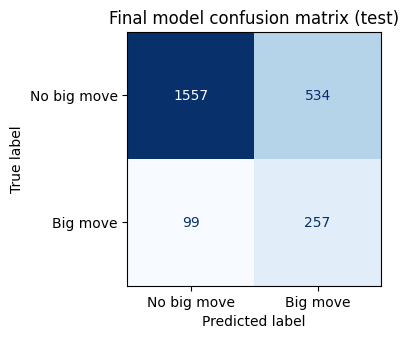

In [46]:
# Confusion matrix – final model
y_pred_final = (y_prob_test_best >= 0.5).astype(int)
cm = confusion_matrix(y_test_grid, y_pred_final)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No big move", "Big move"]
)
fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax_cm, values_format='d', cmap="Blues", colorbar=False)
ax_cm.set_title("Final model confusion matrix (test)")
plt.tight_layout()
plt.show()

out_path_cm = "plots/final_confusion_matrix.png"
fig_cm.savefig(out_path_cm, dpi=150, bbox_inches="tight")

/Users/derekkuang/cse158_assignment2/.venv/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning:

`**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.

/Users/derekkuang/cse158_assignment2/.venv/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning:

`**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.



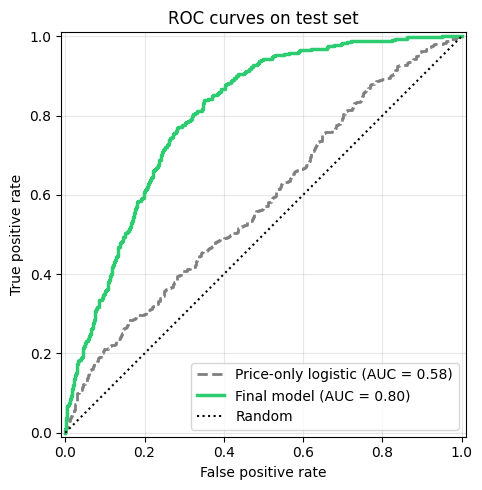

In [47]:


fig_roc, ax_roc = plt.subplots(figsize=(5, 5))

# Price-only logistic (gray, dashed)
RocCurveDisplay.from_predictions(
    y_test_eval,
    probs_price,
    name="Price-only logistic",
    ax=ax_roc,
    color="gray",
    linestyle="--",
    linewidth=2,
)

# Final tuned model (strong green)
RocCurveDisplay.from_predictions(
    y_test_grid,
    y_prob_test_best,
    name="Final model",
    ax=ax_roc,
    color="#2ECC71",
    linewidth=2.5,
)

# Random baseline
ax_roc.plot(
    [0, 1], [0, 1],
    linestyle=":",
    color="black",
    linewidth=1.5,
    label="Random"
)

ax_roc.set_title("ROC curves on test set")
ax_roc.set_xlabel("False positive rate")
ax_roc.set_ylabel("True positive rate")

# Light grid to make reading off points easier
ax_roc.grid(True, alpha=0.3)

ax_roc.legend(loc="lower right")

plt.tight_layout()

out_path_roc = "plots/roc_price_vs_final.png"
fig_roc.savefig(out_path_roc, dpi=150, bbox_inches="tight")

plt.show()